In [37]:
from collections import defaultdict
import random as rd, numpy as np, networkx as nx, matplotlib.pyplot as plt
import pandas as pd

# Criando grafo
n_nodes = 10000
prob = 5/n_nodes
G = nx.erdos_renyi_graph(n_nodes,prob)

# Construindo matriz de adjacencia
dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
adj_mtz = {}
for i in sordic:
    adj_mtz.update({i:dic[i]})

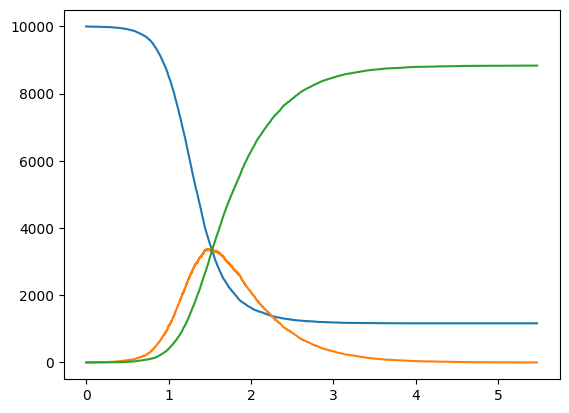

In [38]:
# Vértices infectados e recuperados iniciais
#k = round(n_nodes*0.05)  # K infectados
#lst = list(np.arange(n_nodes))
#initial_infecteds = rd.sample(lst, k=k) # K vértices aleatórios 

initial_infecteds = [0]
initial_recovereds = []

# Tempo
tmin = 0
#tmax = 100
t = tmin

# Listas para plot
I = [len(initial_infecteds)]
R = [len(initial_recovereds)]
S = [n_nodes-I[0]-R[0]]
times = [tmin]

# Crio um dicionário com o status 'S' e vou trocando os indices dos infectados para 'I' ou 'R'
status = defaultdict(lambda : 'S')

#for node in initial_recovereds:
#    status[node] = 'R'

# Número de infectados
infecteds = 0

# Parâmetros de recuperação
ar = 1.5
μr = 1

# Parâmetros de infecção
ai = 1
μi = 2

d = {'Evento':[], 'nó/link':[], 'Taxa':[], 'Elapsed Times':[]}
Eventos_Inf = pd.DataFrame(data=d)
Eventos_Rec = pd.DataFrame(data=d)

for node in initial_infecteds:
    
    # Para cada nó infectado crio um evento de recuperação e adiciono uma linha no dataframe
    status[node] = 'I'
    Agente = node
    et = 7
    Taxa = ar*μr**(ar)*et**(ar-1)
    
    # Data frame    
    DataF = pd.DataFrame({'Evento':['Rec'], 'nó/link':[Agente], 'Taxa':[et], 'Elapsed Times':[Taxa]})
    Eventos_Rec = pd.concat([Eventos_Rec,DataF], axis=0, ignore_index=True)
    
    # Aumento o número de infectados
    infecteds += 1
    
    # Se ele tem algum vizinho suscetível, crio um link entre ele e o suscetível.
    for nbr in list(adj_mtz[node]):  #must have this in a separate loop from assigning status
        if status[nbr] == 'S':
            
            # Adiciono o link no Dataframe com as características
            Agente = (node,nbr)
            et = 7
            Taxa = ai*μi**(ai)*et**(ai-1)
            
            # Crio o evento
            DataF = pd.DataFrame({'Evento':['Inf'], 'nó/link':[Agente], 'Taxa':[et], 'Elapsed Times':[Taxa]})
            Eventos_Inf = pd.concat([Eventos_Inf,DataF], axis=0, ignore_index=True)
            
while infecteds > 0:
    
    # Atualizar tempo
    delay = -np.log(rd.random())/(Eventos_Inf['Taxa'].sum()+Eventos_Rec['Taxa'].sum())
    t += delay

    
    # Atualizar elapsed Times
    
    
    Eventos_Inf['Elapsed Times'] = Eventos_Inf['Elapsed Times'] + delay
    Eventos_Inf['Taxa'] = ai*μi**(ai)*(Eventos_Inf['Taxa']+delay)**(ai-1)

    Eventos_Rec['Elapsed Times'] = Eventos_Rec['Elapsed Times'] + delay
    Eventos_Rec['Taxa'] = ar*μr**(ar)*(Eventos_Rec['Taxa']+delay)**(ar-1)
    
    
    # Sorteando evento com peso nas taxas
    Process = pd.concat((Eventos_Inf,Eventos_Rec))
    Process = Process[Process['Elapsed Times']>0]
    peso = Process['Taxa']
    Sorteado = Process.sample(weights=peso)

    
    # Processo de recuperação:
    if Sorteado['Evento'][Sorteado.index[0]] == 'Rec':
    
        Indice = Sorteado.index[0]
        recovering_node = Eventos_Rec.loc[Indice]['nó/link']
        
        # Atualizo o status e taxas
        status[recovering_node]='R'
        
        # Diminuo a lista de infectados
        infecteds -= 1
        
        # Removo o evento do Dataframe
        Eventos_Rec = Eventos_Rec.drop(Indice)
        
        # Removo os links deste infectado com os suscetíveis que ele havia.
        for nbr in list(adj_mtz[recovering_node]):
            if status[nbr] == 'S':
                
                # Coleto o Indice
                Indice_l = Eventos_Inf[Eventos_Inf['nó/link']==(recovering_node,nbr)].index.values[0]
                
                # Destruo o link
                Eventos_Inf = Eventos_Inf.drop(Indice_l)
                
        times.append(t)
        S.append(S[-1])
        I.append(I[-1]-1)
        R.append(R[-1]+1)


    # Processo de Infecção
    elif Sorteado['Evento'][Sorteado.index[0]] == 'Inf':
        
        Indice = Sorteado.index[0]
        inf, new_inf = Eventos_Inf.loc[Indice]['nó/link']
        
        # Atualizo status do vértice
        status[new_inf]='I'
        
        # Adiciono na lista de infectados o suscetível
        infecteds += 1

        # Crio um evento de recuperação e adiciono uma linha no dataframe
        Agente = new_inf
        et = 0
        Taxa = 0

        # Data frame
        DataF = pd.DataFrame({'Evento':['Rec'], 'nó/link':[Agente], 'Taxa':[et], 'Elapsed Times':[Taxa]})
        Eventos_Rec = pd.concat([Eventos_Rec,DataF], axis=0, ignore_index=True)
        
        # Crio os links deste novo infectado com os suscetíveis ao seu arredor.
        for nbr in list(adj_mtz[new_inf]):

            if status[nbr] == 'S':
                
                # Adiciono o link no Dataframe com as características
                Agente = (new_inf, nbr)
                et = 0
                Taxa = 0 # Inicia com 0 e depois é atualizada.  

                DataF = pd.DataFrame({'Evento':['Inf'], 'nó/link':[(new_inf,nbr)], 'Taxa':[et], 'Elapsed Times':[Taxa]})
                Eventos_Inf = pd.concat([Eventos_Inf,DataF], axis=0, ignore_index=True)
                
            # Removo as conexões que haviam entre algum infectado e este vértice que era suscetível
            elif status[nbr] == 'I': #and nbr != recipient:
     
                # Coleto o Indice
                Indice = Eventos_Inf[Eventos_Inf['nó/link']==(nbr,new_inf)].index.values[0]
                
                # Destruo o link
                Eventos_Inf = Eventos_Inf.drop(Indice)

        times.append(t)
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])

    
plt.plot(times,S)
plt.plot(times,I)
plt.plot(times,R)